### Imports

In [1]:
from google.colab import drive
from torch.utils.data import Dataset, DataLoader

import kagglehub
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.calibration import LabelEncoder
import torch.nn.functional as F
import torch.nn as nn
import os

import torchvision
from torchvision.transforms import v2
from torchvision.io import decode_image
import torchvision.transforms as transforms
# import torchvision.transforms as transforms

### Colab Configurations

In [2]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
!ls
!ls "/content/drive/My Drive/Colab Notebooks/rice_classification"

drive  sample_data
Rice_Image_Dataset  Rice_Image_Dataset.zip


In [3]:
os.chdir("/content/drive/My Drive/Colab Notebooks/rice_classification")
print("Now working in:", os.getcwd())

Now working in: /content/drive/My Drive/Colab Notebooks/rice_classification


In [ ]:
# run one-time
# !unzip -q "Rice_Image_Dataset.zip" -d "./"

In [ ]:
# path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

# print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rice-image-dataset


### Loading images

In [4]:
rice_classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
# path_to_imgs = "~/kaggle/input/rice-image-dataset"
path_to_imgs = './Rice_Image_Dataset/'

img_paths = []
labels = []

display(os.path.join(path_to_imgs, rice_classes[0]))
display(os.listdir(path_to_imgs))

for rice_name in rice_classes:
    class_path = os.path.join(path_to_imgs, rice_name)

    for item in os.listdir(class_path)[:]:
        img_path = os.path.join(class_path, item)
        img_paths.append(img_path)
        labels.append(rice_name.lower())


'./Rice_Image_Dataset/Arborio'

['Rice_Citation_Request.txt',
 'Basmati',
 'Ipsala',
 'Jasmine',
 'Karacadag',
 'Arborio']

In [5]:
rice_images_df = pd.DataFrame({'paths': img_paths, 'labels': labels})

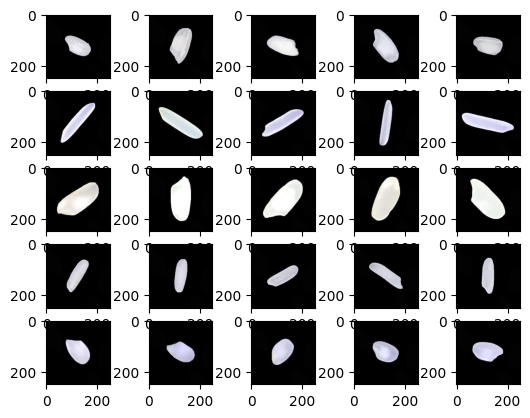

In [6]:
IMGS_TO_SAMPLE = 5


imgs_by_labels = rice_images_df.groupby('labels')
sampled_df = imgs_by_labels.sample(IMGS_TO_SAMPLE, random_state = 0).reset_index()

for i in range(sampled_df.shape[0]):
    img = plt.imread(sampled_df.iloc[i]['paths'])
    plt.subplot(5, 5, i+1)
    plt.imshow(img)


### Exploratory data analysis

(0.0, 20000.0)

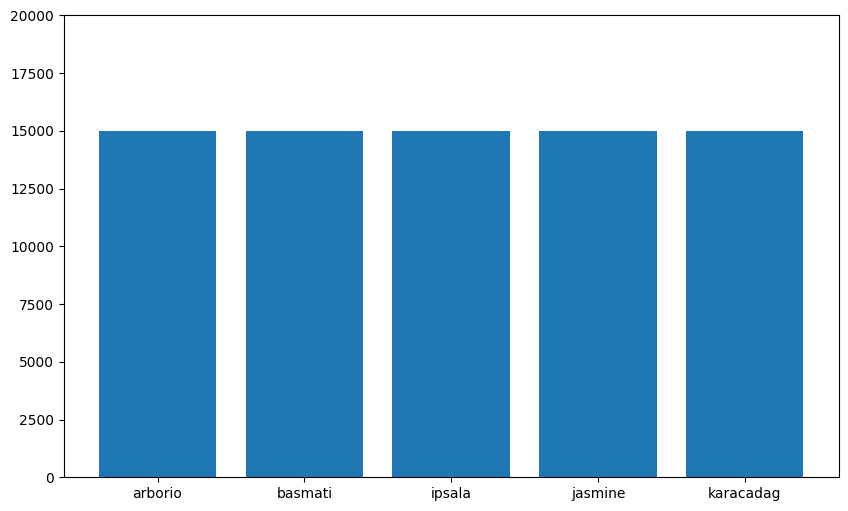

In [7]:
# figuring out class statistics
class_dist = rice_images_df['labels'].value_counts()

plt.figure(figsize = (10, 6))
plt.bar(
    class_dist.index.to_list(),
    class_dist.values
)
plt.ylim(0, 20000)

### Image transformer

Image([[[0.7373, 0.7333, 0.7373,  ..., 0.0000, 0.0000, 0.0000],
        [0.7373, 0.7333, 0.7333,  ..., 0.0000, 0.0000, 0.0000],
        [0.7451, 0.7373, 0.7294,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.8706, 0.8784, 0.8941],
        [0.0000, 0.0000, 0.0000,  ..., 0.8745, 0.8745, 0.8706],
        [0.0000, 0.0000, 0.0000,  ..., 0.8784, 0.8745, 0.8706]]], )

torch.Size([1, 75, 75])

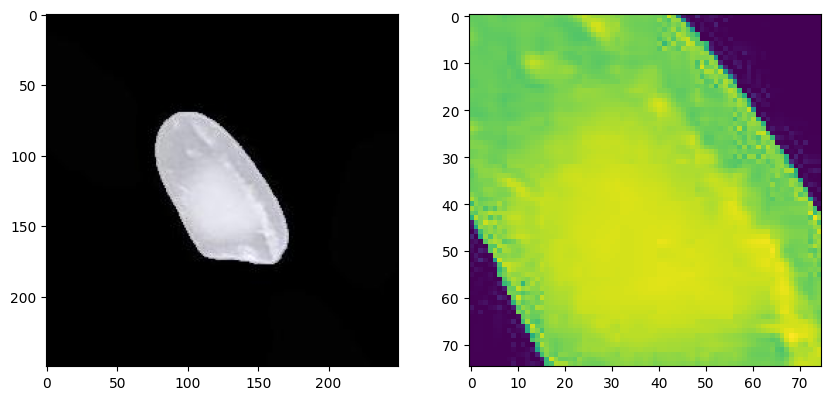

In [8]:
# proof of concept
plt.figure(figsize = (10, 5))
# test_img = plt.imread(rice_images_df.iloc[10]['paths'])
test_img = decode_image(rice_images_df.iloc[10]['paths'])
plt.subplot(1, 2, 1)

t = test_img.permute(1, 2, 0)
plt.imshow(t)


# image_transforms = v2.Compose([
#     v2.CenterCrop((10, 10)),
#     # v2.Grayscale(num_output_channels = 1)
#     # v2.Resize(size = (200, 200)),
#     v2.Grayscale(num_output_channels=1)
# ])

# image_transforms = v2.RandomCrop(size = (100, 100))

# image_transforms = v2.Grayscale(num_output_channels=1)
# image_transforms = v2.CenterCrop(size = (75, 75))
image_transforms = v2.Compose([
    v2.CenterCrop(size = (75, 75)),
    v2.Grayscale(num_output_channels=1)
])

image_transforms = v2.Compose([
    v2.CenterCrop(size = (75, 75)),
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True)
])

test_img2 = image_transforms(test_img)
plt.subplot(1, 2, 2)
t2 = test_img2.permute(1, 2, 0)
plt.imshow(t2)
display(test_img2)
display(test_img2.shape)

In [9]:
# setting up transforms
rice_transforms = v2.Compose([
    # to tensor
    v2.Grayscale(num_output_channels = 1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

### Image Dataset

In [10]:
# custom dataset for transforms
class RiceImageDataset(Dataset):

  def __init__(self, images_df, transforms):
    # self.img_labels = img_labels
    # self.img_paths = img_paths
    self.images_df = images_df
    self.transforms = transforms

  def __len__(self):
    return self.images_df.shape[0]

  def __getitem__(self, id):
    # retrieve image at id
    img_path = self.images_df.iloc[id]['paths']
    img_label = self.images_df.iloc[id]['labels']
    img_file = decode_image(img_path)

    transformed_image = self.transforms(img_file)
    # transformed_image = transformed_image.permute(1, 2, 0)

    return transformed_image, img_label

  def get_data_df(self):
    return self.images_df


In [11]:
# custom Trainer class
class RiceTrainer:
  def __init__(self):
    self.train_losses = []
    self.val_losses = []
    self.mean_train_losses = []
    self.mean_val_losses = []
    self.seed = 0
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  def prepare_data(self, dataframe, test_size, batch_size, rice_transforms):
    self.dataframe = dataframe
    self.test_size = test_size
    self.batch_size = batch_size

    # partition the data
    X_train, X_test, y_train, y_test = train_test_split(
        dataframe, dataframe['labels'].values,
        test_size=self.test_size,
        shuffle = True
    )

    # create RiceDatasets
    self.train_ds = RiceImageDataset(X_train, rice_transforms)
    self.test_ds = RiceImageDataset(X_test, rice_transforms)

    # feed into data loader
    self.train_loader = DataLoader(
        RiceImageDataset(X_train, rice_transforms),
        batch_size = batch_size,
        generator = torch.Generator(device=self.device).manual_seed(self.seed)
    )
    self.test_loader = DataLoader(
        RiceImageDataset(X_test, rice_transforms),
        batch_size = 1,
        generator = torch.Generator(device = self.device).manual_seed(self.seed)
    )

  def train_loop(self, num_epochs, model, optimizer, show_plot=False):
    model.train()   # sets the model to train (for dropout and batchnorm)

    for epoch in range(num_epochs):
      # get new batches of X, y
      for X_batch, y_batch in self.train_loader():

        # forward pass and get loss
        loss = model.loss(model(X_batch), y_batch)
        self.train_losses.append(loss)

        optimizer.zero_grad()   # prepare optimizer
        model.backward(y_batch)
        optimizer.step()

    # maybe plot losses
    if show_plot:
      plt.figure(figsize = (10, 6))
      plt.plot(
          np.arange(len(self.train_losses)),
          self.train_losses,
          label = "Training Loss"
      )
      plt.set_title("Training Loss")
      plt.legend()
      plt.show()


  def test_loop(self, model, show_plot = False):
    model.eval()

    # validation losses
    for X_batch, y_batch in self.test_loader():
      model.eval()
      loss = model.loss(model(X_batch), y_batch)
      self.val_losses.append(loss)

    # plot losses
    if show_plot:
      plt.figure(figsize = (10, 6))
      plt.plot(
          np.arange(len(self.val_losses)),
          self.val_losses,
          label = "Validation Loss"
      )
      plt.set_title("Validation Loss")
      plt.legend()
      plt.show()


### Splitting data and encoding

In [12]:
from sklearn.calibration import LabelEncoder


le = LabelEncoder()
rice_images_df['labels'] = le.fit_transform(
    rice_images_df['labels']
)

In [13]:
# looking at basic data
ds = RiceImageDataset(rice_images_df, rice_transforms)
tl = DataLoader(ds, batch_size = 5, shuffle = True)
for X, y in tl:

  print(X.shape)
  print(y)
  # print(X[0,0])
  # print(np.unique(X[0, 0]))
  break

torch.Size([5, 1, 250, 250])
tensor([0, 0, 0, 0, 3])


### Custom CNN

In [14]:
class BasicRiceCNN(nn.Module):

  def __init__(self, img_channels, num_classes, image_size):
    super().__init__()

    # define layers

    # conv layer

    OUT_CHANNELS = 1
    # KERNEL_SIZE = (5, 5)
    KERNEL_SIZE = 2
    # STRIDE = (1, 1)
    STRIDE = 1
    # PADDING = (0, 0)
    PADDING = 0
    self.conv = nn.Conv2d(
        img_channels,
        OUT_CHANNELS,
        KERNEL_SIZE,
        STRIDE,
        PADDING)

    # maybe batchnorm?
    self.batch_norm = nn.BatchNorm2d(OUT_CHANNELS)

    # ReLU layer
    self.relu = nn.ReLU()

    # max-pool layer
    POOL_SIZE = 2
    self.max_pool = nn.MaxPool2d(kernel_size = POOL_SIZE, stride = POOL_SIZE)

    # flattened
    self.flatten = nn.Flatten()

    # fully-connected
    # calculate output size of conv2d following:
    # 1. batchnorm, 2. ReLU, 3. max_pool
    calc_output_size = image_size + 2 * PADDING - KERNEL_SIZE + STRIDE
    calc_output_size = (calc_output_size / STRIDE) + 1
    calc_output_size = calc_output_size / POOL_SIZE

    self.fc = nn.Linear(calc_output_size, num_classes)

    # as a block
    # self.conv_block = nn.Sequential(
    #     nn.Conv2d(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, STRIDE, PADDING),
    #     nn.ReLU(),
    #     nn.MaxPool2d(POOL_SIZE)
    # )

  def forward(self, X):

    # through standard layers
    x = self.conv(X)
    x = self.relu(x)
    x = self.max_pool(x)
    x = self.fc(x)

    return x

In [15]:
TEST_SIZE = 0.1
BATCH_SIZE = 15

# define trainer
trainer = RiceTrainer()
trainer.prepare_data(rice_images_df, TEST_SIZE, BATCH_SIZE, rice_transforms)

model = BasicRiceCNN(1, 5, 250)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

trainer.train_loop(1, model, optimizer, show_plot = True)

RuntimeError: Trying to create tensor with negative dimension -1: [5, -1]

### Setup GPU device

In [ ]:
def get_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = get_device()
type(device)

torch.device

In [ ]:
class DenseLayer(nn.Module):

    def __init__(self, num_features, num_neurons, activation_fn = torch.nn.Sigmoid,
                 loss_fn):
        self.num_features = num_features
        self.num_neurons = num_neurons
        self.activation_fn = activation_fn()
        self.loss_fn = loss_fn

        gen = torch.Generator()
        gen.manual_seed(0)

        self.init_weights()

    def init_weights(self):
        self.W = torch.normal(0, 0.1, size = (self.num_features, self.num_neurons))
        self.b = torch.zeroes((1, self.num_neurons))
        # self.z = torch.zeros(())

    def forward(self, X):
        pre_activated = X @ self.W + self.b
        activated = self.activation_fn(pre_activated)

        return activated

In [ ]:
class ConvLayer(nn.Module):

  def __init__(self, kernel_size, padding, stride, dilation):
    self.kernel_size = kernel_size
    self.padding = padding
    self.stride = stride
    self.dilation = dilation

  def forward():

    pass


  def backward():

    pass